In [3]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Edward's Curve

Criamos uma classe que representa uma curva de Edward, que para dado parâmetro, irá conter as funções para criar o gráfico da curva, a soma entre dois pontos, a multiplicação de um ponto por um inteiro e inverso de um ponto.

In [5]:
class EdwardCurve:
    """
    Implementation of Edward's curve (Edward's form of elliptic curves) for criptography of the form:
    x^2+ y^2 = 1 + d * x^2 * y^2       for d not  in {0, 1}

    

    Reference:
        https://en.wikipedia.org/wiki/Edwards_curve#cite_ref-Daniel._J_Bernstein_,_Tanja_Lange_1-0
    """
    def __init__(self, d):

        assert d != 0 and d != 1

        self.d = d
        
    def plot(self, ax = None):
        
        if ax == None:
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111) 

        #If d < 0, the solution of the equation is inside the square [-1, 1] X [-1, 1]
        # For the fixed value of x in [-1, 1], solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        if self.d < 0:
            xs = np.concatenate([
                np.arange(-1, -0.9, 0.01), 
                np.arange(-0.9, -0.1, 0.1),
                np.arange(-0.1, 0.1, 0.01),
                np.arange(0.1, 0.9, 0.1),
                np.arange(0.9, 1.01, 0.01)])

            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])
            ax.plot(xs, ys)

        # If d > 1, the possible x vales are on the set S = (-inf, -1) \cup (-1/d, 1/d) \cup (1, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        elif self.d > 1:
            xs = np.concatenate([np.arange(-10, -2, 1), np.arange(-2, -1.01, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs, xs[::-1]])
            ys = np.concatenate([ys, -ys[::-1]])

            ax.plot(xs, ys)

            xs = np.concatenate([np.arange(1, 2, 0.01), np.arange(2, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            xs = np.concatenate([xs[::-1], xs])
            ys = np.concatenate([ys[::-1], -ys])

            ax.plot(xs, ys)

            xs = np.arange(-1/self.d, 1/self.d, 0.01)
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))

            ax.plot(xs, ys)
            ax.plot(xs, -ys)

        # If d in (0, 1), then 1/d > 1, so S = (-inf, -1/d)  \cup (1/d, inf)
        # For the fixed value of x in S, solve the quadratic equation y^2 (1 - d * x^2) + (x^2 - 1) = 0
        else:
            xs = np.concatenate([np.arange(-10, -1/self.d -1, 1), np.arange(-1/self.d - 1, -1/self.d, 0.01)])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            ax.plot(xs, ys)
            ax.plot(xs, -ys)

            xs = np.concatenate([np.arange(1/self.d, 1/self.d + 1, 0.01), np.arange(1/self.d + 1, 10, 1), ])
            delta = 4 * (self.d * xs* xs - 1) * (xs * xs - 1)
            ys = np.sqrt(delta) / (2 * (1 - self.d * xs * xs))
            ax.plot(xs, ys)
            ax.plot(xs, -ys)

        plt.show()

## Gráfico interativo com o parâmetro d

<IPython.core.display.Javascript object>


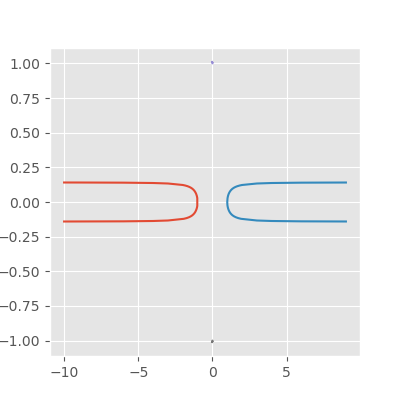

interactive(children=(IntSlider(value=-2, description='d', max=50, min=-50, step=2), Output()), _dom_classes=(…

In [13]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111) 

def draw_EdC(d):
    if d == 0 or d == 1:
        return
    ax.clear()
    cur_edc = EdwardCurve(d)
    cur_edc.plot(ax)
    
interact(draw_EdC, d=widgets.IntSlider(min=-50,max=50,step=2,value=-2));